# Module 4 Assignment
Sarah Henry

Submit this code as a pull request back to GitHub Classroom by the date and time listed in Canvas.

For this assignment, use the ERA-5 monthly mean data from Copernicus Data Service.

1. Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download

2. From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. (code below)


In [1]:
import numpy as np
import xarray as xr

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z



# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
# ds = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed
# ds = ds.chunk({"valid_time": -1})

# detr = linear_detrend(ds[["sst", "tcrw"]], time_dim="valid_time")   # or just ds if you want all float vars
# anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
#                              base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

# print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']


Then, standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: 6.3. Preprocessing data — scikit-learn 1.1.2 documentation

3. Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

4. Plot the percent of variance explained by the first 10 EOFs.

5. Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

6. Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot). See anything interesting?


## 1. Create dataset

In [2]:
ds = xr.open_dataset("./datasets/ERA5_J-D_1979-2024_mon.nc")
# adjust from (-180,180) to (0,360) to allow for cross-dateline slicing
ds = ds.assign_coords(longitude=((ds.longitude + 360) % 360))
ds = ds.sortby("longitude")
ds_pacific = ds.sel(longitude=slice(120, 300))
print(ds_pacific)

<xarray.Dataset> Size: 2GB
Dimensions:     (valid_time: 552, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 4kB 1979-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
    expver      (valid_time) <U4 9kB ...
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
Data variables:
    sst         (valid_time, latitude, longitude) float32 829MB ...
    tcrw        (valid_time, latitude, longitude) float32 829MB ...
    lsm         (valid_time, latitude, longitude) float32 829MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-21T18:04 GRIB to CDM+CF via cfgrib-0.9.1...


## 2. Compute anomalies

In [3]:
# # chunk for performance
# ds = ds.chunk({"valid_time": 12, "latitude": 100, "longitude": 100})

# # first, detrend data with helper function
# ds_detrend = linear_detrend(ds_pacific[["sst", "tcrw"]], time_dim="valid_time")

# # next, remove monthly climatology
# anom, z = monthly_anom_and_z(ds_detrend, time_dim="valid_time")

# # finally, standardize the data
# # subtract the anomalies by the LTM and divide by STD
# anom_standardized = (anom-anom.mean(dim="valid_time",skipna=True))/anom.std(dim="valid_time",skipna=True)

# # save to avoid reprocessing later
# anom_standardized.to_netcdf("./datasets/ERA5_anom_standardized")

In [4]:
anom_standardized = xr.open_dataset("./datasets/ERA5_anom_standardized")

## 3. EOF analysis

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from eofs.xarray import Eof
from eofs.examples import example_data_path

In [6]:
sst = anom_standardized["sst"]
sst = sst.rename({'valid_time': 'time'})
coslat = np.cos(np.deg2rad(sst.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst, weights=wgts)

/home/smhenry2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [7]:
eofs_corr = solver.eofsAsCorrelation(neofs=5)
pcs = solver.pcs(npcs=5, pcscaling=1)

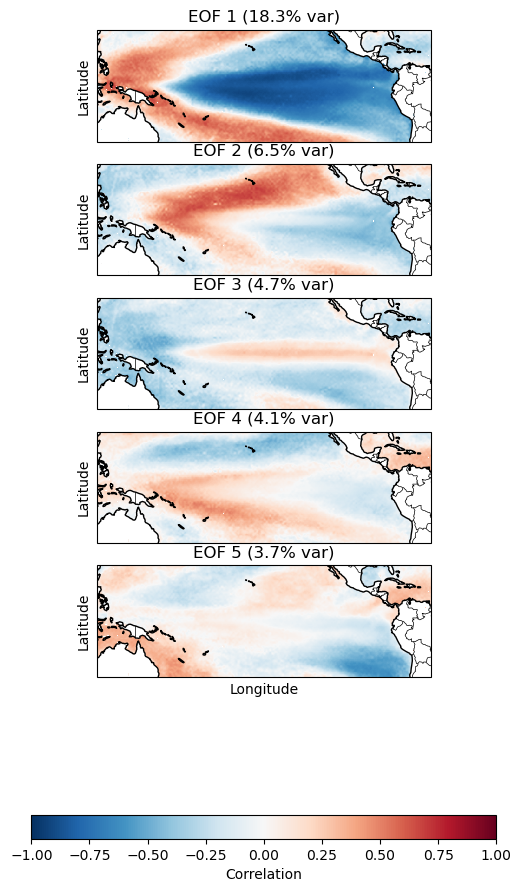

In [8]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 12),
    subplot_kw={'projection': proj},
    sharex=True
)

for i, ax in enumerate(axes):
    eof_map = eofs_corr.isel(mode=i)
    im = eof_map.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap='RdBu_r',
        vmin=-1, vmax=1,
        add_colorbar=False
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
    ax.set_yticks([])
    ax.set_ylabel("Latitude")

    ax.set_title(f'EOF {i+1} ({solver.varianceFraction().isel(mode=i).values*100:.1f}% var)')

ax.set_xticks([])
ax.set_xlabel('Longitude')
cbar = fig.colorbar(im, ax=axes, orientation='horizontal', shrink=0.5)
cbar.set_label('Correlation')

plt.show()

## 4. % var of first 10 EOFs

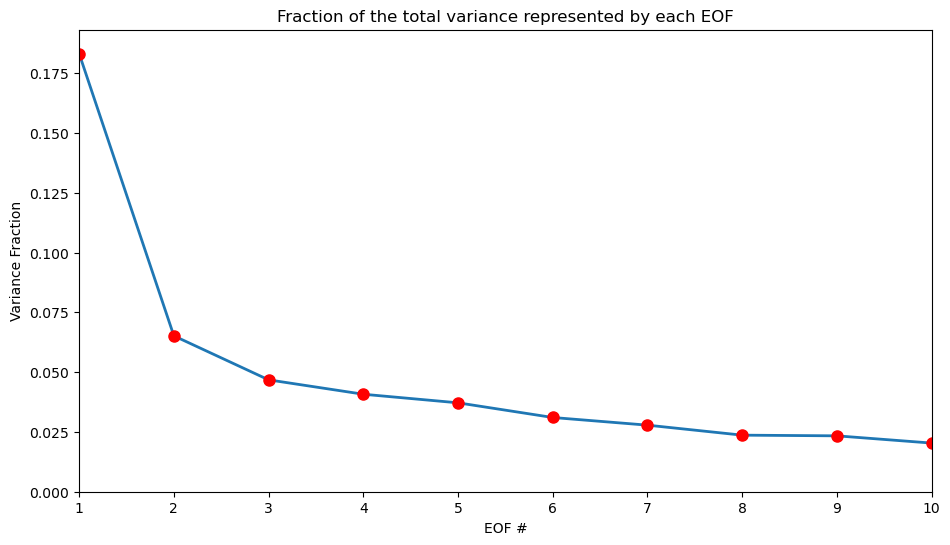

In [9]:
varfrac = solver.varianceFraction()
plt.figure(figsize=(11,6))
eof_num = range(1, 12)
plt.plot(eof_num, varfrac[0:11], linewidth=2)
plt.plot(eof_num, varfrac[0:11], linestyle='None', marker="o", color='r', markersize=8)
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
plt.show()

## 5. Reconstruct and plot corr

In [10]:
neofs = 5
reconstructed_anom_std = xr.dot(
    pcs.isel(mode=slice(0, neofs)),
    solver.eofs(neofs=neofs),
    dims="mode"
)

In [11]:
sst_mean = sst.mean(dim="time", skipna=True)
sst_std = sst.std(dim="time", skipna=True)
reconstructed_sst = reconstructed_anom_std * sst_std + sst_mean # unstandardized

/home/smhenry2/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [12]:
time = np.arange(sst.time.size)
t = xr.DataArray(time, dims="time")
slope = ((t - t.mean()) * (sst - sst.mean("time"))).mean("time") / ((t - t.mean())**2).mean("time")
intercept = sst.mean("time") - slope * t.mean()
trend = slope * t + intercept

In [13]:
sst_reconstructed_retrend = reconstructed_sst + trend - trend.mean("time")

In [14]:
sst_reconstructed_retrend = sst_reconstructed_retrend.chunk({"latitude": 16, "longitude": 16})
sst = sst.chunk({"latitude": 16, "longitude": 16})
corr_map = xr.corr(sst_reconstructed_retrend, sst, dim="time")

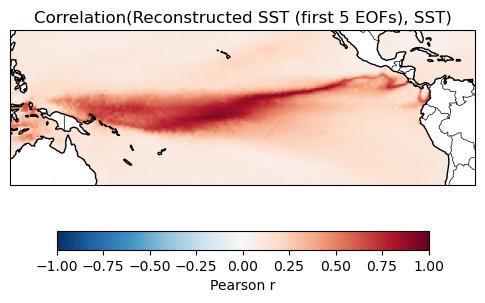

In [15]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(6, 4), subplot_kw={"projection": proj})
im = corr_map.plot(
    ax=ax, transform=ccrs.PlateCarree(),
    cmap="RdBu_r", vmin=-1, vmax=1,
    add_colorbar=False
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())
cbar = plt.colorbar(im, ax=ax, orientation="horizontal", shrink=0.8)
cbar.set_label("Pearson r")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Correlation(Reconstructed SST (first 5 EOFs), SST)")
plt.show()

## 6. Correlation between SST EOF1, and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies

In [18]:
TCRW = anom_standardized["tcrw"].chunk({"latitude": 16, "longitude": 16, "valid_time": -1})
pc1 = pcs.isel(mode=0).rename({"time": "valid_time"})

pc1_mean = pc1.mean("valid_time")
TCRW_mean = TCRW.mean("valid_time")

num = ((TCRW - TCRW_mean) * (pc1 - pc1_mean)).mean("valid_time")
den = np.sqrt(
    ((TCRW - TCRW_mean) ** 2).mean("valid_time")
    * ((pc1 - pc1_mean) ** 2).mean("valid_time")
)

corr_tcrw = (((TCRW - TCRW_mean) * (pc1 - pc1_mean)).mean("valid_time")
            / np.sqrt(
                        ((TCRW - TCRW_mean) ** 2).mean("valid_time")
                        * ((pc1 - pc1_mean) ** 2).mean("valid_time")
                    ))
corr_tcrw = corr_tcrw.compute()

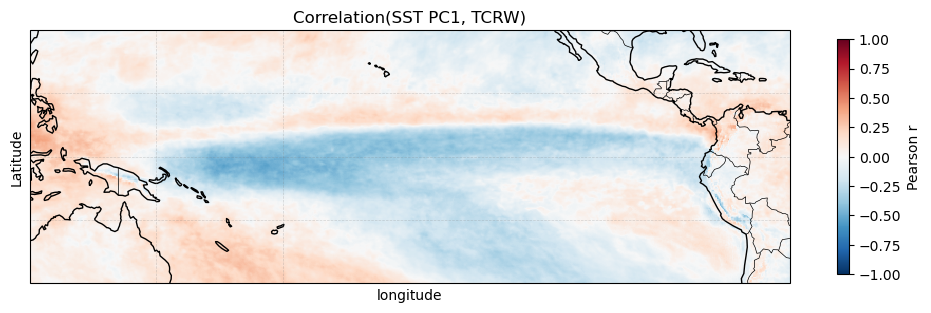

In [22]:
proj = ccrs.PlateCarree(central_longitude=180)
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": proj})

im = corr_tcrw.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    cbar_kwargs={"label": "Pearson r",
                 "shrink": 0.5}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([120, 300, -30, 30], crs=ccrs.PlateCarree())

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel("Latitude")

gl = ax.gridlines(draw_labels=False, linewidth=0.5, color="gray", alpha=0.3, linestyle="--")
gl.xlocator = plt.FixedLocator([120, 150, 180, 210, 240, 270, 300])
gl.ylocator = plt.FixedLocator([-30, -15, 0, 15, 30])

plt.title("Correlation(SST PC1, TCRW)")
plt.tight_layout()
plt.show()


In [23]:
print(corr_tcrw.min())

<xarray.DataArray ()> Size: 4B
array(-0.54767853, dtype=float32)
Coordinates:
    mode     int64 8B 0


From the plot of the Pearson r correlation between the first PC of SST and the total columnar rain water, there is a negative correlation between the leading mode of SST and precipitation with a minimum of -0.55. The region of negative correlation is similar to the anomalies explained by the first five modes, but with a narrower spatial area in the eastern pacific.